# Backpropagation Notebook: Round 2
#### ~Now with Cross Entropy and Softmax~ 
(MNIST Feed-Forward Implementation at the Bottom) 

Design Your Own Adventure Project: QEA Spring 2018  
Hwei-Shin Harriman

In [143]:
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
import copy

In [144]:
def sigmoid(aj):
    #Calculates the sigmoid function using logistic
    return 1 / (1 + np.exp(-aj))

In [145]:
def softmax(s):
    #Calculates the softmax of the output layer
    return np.exp(s) / np.sum(np.exp(s))

In [146]:
def sigPrime(z):
    return (z * (1 - z))

In [147]:
def calcAj(weights, prevLayerOut):    
    #Calculates the sum of the weights and outputs from previous 
    #prevLayerOut and weights must be np arrays
    #weights should be one ROW of the weights matrix
    #prevLayerOut should be a ROW vector
    return np.dot(weights, prevLayerOut)

In [148]:
#given matrix of weights, number of nodes per hidden layer,
#and an input vector of data, propagate forward for one layer

def calcLayerOutputs(inputVec, weights):
    #define vector of output activations for all units in current layer
    
    return sigmoid(np.matmul(weights, inputVec))

In [149]:
def crossEntError(netOutput, target):
    #Takes 2 vectors of same dimensions, returns the sum-of-squares error
    return -1 * np.sum(target * np.log(netOutput))

In [150]:
def calcDelta(netOutput, target):
    #Takes 2 np arrays, all activations from forward prop and actual target
    #returns delta value for each output neuron
    #assumes netOutput's last entry is activations of output layer
    guesses = netOutput[-1]

    return (guesses - target)

In [151]:
#neuronsPerLayer = array with number of neurons in each hidden/output layer
def forwardprop(inputVec, weights):
    #calculates outputs for all neurons in network
    activations = [inputVec]
    
    #dynamically calculates activations for all nodes in network
    for layer in range(len(weights)):
        weightsInLayer = weights[layer]
        
        #Apply sigmoid activation function to hidden units
        if layer < (len(weights) - 1):
            #calculates all activations for current layer
            layerActivations = calcLayerOutputs(activations[layer], weightsInLayer[:, :])
            
            #Save activations without sigmoid function for softmax layer
            #if layer == (len(weights) - 2):
            #    s = np.matmul(weightsInLayer[:,:], activations[layer])
        
        #Apply softmax to output units
        if layer == (len(weights) - 1):
            s = np.matmul(weightsInLayer[:,:], activations[layer])
            layerActivations = softmax(s)
        
        #adds resulting np array to list
        activations.append(layerActivations)
    #should be number of layers * j (neurons per layer) activations
    return activations

In [152]:
def backprop(activations, weights, deltaK):
    #calculates deltas for hidden units
    allDeltas = [deltaK]

    # The index goes from n-2 to 0.
    # The deltas vectors are indexed like the list of weight matrices.
    # The deltas for n-1 (the last weight matrix) are already computed.
    for layer in range(len(weights) - 2, -1, -1):
        #fetches activations from previous layer
        zj = activations[layer + 1] #Using the activations of the next layer
        weightsInLayer = weights[layer + 1] #and the weights of the next layer
        
        #one matrix-vector multiplication and one element-wise vector multiplication
        deltaJs = np.matmul(np.transpose(weightsInLayer), allDeltas[0]) * sigPrime(zj)
        
        #builds list of deltas to have same indexing as weights matrix
        allDeltas.insert(0, deltaJs)

    return allDeltas

In [153]:
#testing functionality of forward propagation

#generate random vector and weight matrix
inputVec = np.random.rand(10)
numLayers = 3
weightMatrix = []
for layer in range(numLayers):
    weightMatrix.append(np.random.randn(10, 10))

#first entry of activations is the input vector
activations = forwardprop(inputVec, weightMatrix)

In [154]:
#test functionality of deltas function
targets = np.array([0., 0., 0., 1., 1., 1. , 0., 0., 1., 0.])

deltas = calcDelta(activations, targets)

In [155]:
#test functionality of backprop
alldeltas = backprop(activations, weightMatrix, deltas)

In [156]:
def calcGradient(learningRate, deltas, activations, weights):
    #for each layer, for each weight @ every node, calculate the gradient
    gradient = []
    for layer in range(len(weights) -1, -1, -1):
        deltaKs = deltas[layer]
        outJs = activations[layer]
        weightDims = weights[layer]
        
        #pre-allocate array to fill with gradient values. Annoyingly defined by [0] * columns * rows
        weightsInLayer = np.array([[0.] * weightDims.shape[1]] * weightDims.shape[0])

        for k in range(len(deltaKs)):
            for j in range(len(outJs)):
                #Note: [k, j] row by column. Think of matrix multiplication.
                weightsInLayer[k,j] =  learningRate * deltaKs[k] * outJs[j]
        
        gradient.insert(0, weightsInLayer)
    return gradient
updatedW = calcGradient(.001, alldeltas, activations, weightMatrix)

In [157]:
def updateWeights(learningRate, deltas, activations, weights):
    #calculate the gradient
    gradComponents = calcGradient(learningRate, deltas, activations, weights)
    
    #update all of the weights based on the gradient
    newWeights = []
    for layer in range(len(weights)):
        weightsInLayer = weights[layer]
        gradInLayer = gradComponents[layer]
        
        #subtract the gradient components from the weights
        newWeights.append(weightsInLayer - gradInLayer)
    return newWeights
newWeights = updateWeights(.001, alldeltas, activations, weightMatrix)

In [158]:
def gradientCheck(weights, inputVec, target):
    # weights is the list of weight matrices
    # inputVec and target is a single training pair
    numBroken = 0
    weights1 = weights
    weights2 = copy.deepcopy(weights)
    
    # Compute error and gradient with current weights
    activations = forwardprop(inputVec, weights)
    deltaK = calcDelta(activations, target)
    deltas = backprop(activations, weights, deltaK)
    gradComponents = calcGradient(1, deltas, activations, weights)
    
    # Check each component of the gradient via numerical differentiation
    # WARNING: Very slow
    eps = 1e-9
    for layer in range(len(weights)): 
        for j in range(weights[layer].shape[0]):
            for k in range(weights[layer].shape[1]):
                # Add / subtract a small number to the current weight
                weights1[layer][j, k] += eps
                weights2[layer][j, k] -= eps

                # Compute the new error
                activations1 = forwardprop(inputVec, weights1)
                activations2 = forwardprop(inputVec, weights2)
                error1 = crossEntError(activations1[-1], target)
                error2 = crossEntError(activations2[-1], target)
                
                #remove the eps value
                weights1[layer][j, k] -= eps
                weights2[layer][j, k] += eps
                
                # Check gradient component vs central difference
                numGrad = (error1 - error2) / (2*eps)
                grad = gradComponents[layer][j, k]
                #print(abs(grad -numGrad))
                if (abs(grad - numGrad) > 1e-4):
                    numBroken += 1
                    print("[", layer, ", ", j, ", ", k, "]")
                    print("ERROR: Wrong gradient component")
                    print("Should be: ", numGrad)
                    print("Is: ", grad)
    return numBroken
inputVec = np.random.rand(10)
numLayers = 3
weightMatrix = []
for layer in range(numLayers):
    weightMatrix.append(np.random.randn(10, 10))
target = np.array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])
gradientCheck(weightMatrix, inputVec, target)

0

2 (10,)


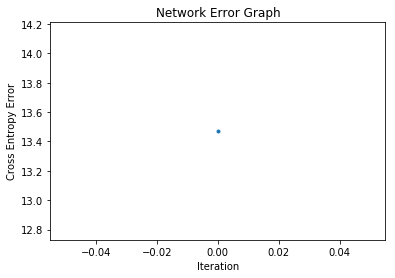

last guess:  8
actual vector:  3
difference:  [ 0.01125364  0.00179635  0.08433571 -0.99534517 -0.98494621 -0.97537773
  0.00213287  0.03200773 -0.18191386  0.00605667]
accuracy:  0.0 %
number of correct guesses:  0
# times Network Error was zero:  0


In [169]:
def trainNetwork(patterns, learningRate, neuronsPerLayer, targets, *weights):
    errors = []
    numCorrect = 0
    numCorrect2 = 0
    
    #Check to see if weights is passed, if so, index so it doesn't become a tuple
    if weights:
        weights = weights[0]
    
    #Else randomly initialize all weights in network
    if not weights:
        weights = []
        #Note: Think of multiplying a weight matrix with an activation vector.
        for layer in range(len(neuronsPerLayer) - 1):
            weights.append(np.random.randn(neuronsPerLayer[layer + 1], neuronsPerLayer[layer]))
    
    #Initialize error plot
    fig, ax = plt.subplots()
    
    #Loop through all input vectors, train the network, plot the error
    for p in range(len(patterns)):
        #PS: Enable this to check if the forward and backward pass are still consistent.
        #    Warning, it's very slow. Use a small network.
        #gradientCheck(weights, patterns[p], targets[p])
        
        #forward pass through network, find all activations
        activations = forwardprop(patterns[p], weights)
        
        #calculate deltas at output layer
        deltaK = calcDelta(activations, targets[p])
        
        #calculate rest of deltas with backpropagation
        allDeltas = backprop(activations, weights, deltaK)
        
        
        #update weights
        weights = updateWeights(learningRate, allDeltas, activations, weights)
        
        #calculate network error
        error = crossEntError(activations[-1], targets[p])
        
        #add to list of errors
        errors.append(error)
        
        #Did the network guess right?
        if np.argmax(activations[-1]) == np.argmax(targets[p]):
            numCorrect += 1
        
        #Other check
        if int(error) == 0:
            numCorrect2 += 1
        
    print(len(allDeltas), allDeltas[1].shape)
    #calculate accuracy
    acc = (numCorrect / len(patterns)) * 100
    
    #plot the error
    ax.plot(errors, marker= '.')
    ax.set(xlabel = 'Iteration', ylabel= 'Cross Entropy Error', title= 'Network Error Graph')
    plt.show()
    
    print("last guess: ", np.argmax(activations[-1]))
    print("actual vector: ", np.argmax(targets[-1]))
    print("difference: ", (activations[-1] - targets[-1]))
    print("accuracy: ", acc, "%")
    print("number of correct guesses: ", numCorrect)
    print("# times Network Error was zero: ", numCorrect2)
    return weights
test = trainNetwork([inputVec], .001, [10, 10, 10], [targets])

## MNIST Feed-Forward Implementation

Feed-forward neural network with one input layer, two hidden layers with 625 units each, and one output layer of 10 units. Learning rate is currently .05, stochastic gradient descent is not implemented. Uses softmax transfer function on output layer, error function is cross entropy. Has epoch capability, and the testing function also has the option to visualize the guesses the network made correctly or incorrectly. Takes a while to run, so only use the small MNIST dataset.

In [170]:
def make_dataset(trainfile, testfile):
    #Takes name of training set and test set, breaks into input vectors and targets
    #Initializes arrays that will contain data set
    imgtr = []
    tartr = []
    imgte = []
    tarte = []
    numOutputs = 10
    
    #Opens training data set
    fd = open(trainfile, 'r')
    loaded = fd.readlines()
    fd.close()
    
    fdtr = open(testfile, 'r')
    loadedtr = fdtr.readlines()
    fdtr.close()

    #Pre-process the training data set
    for line in loaded:
        #reset options
        opt = np.array([0.] * numOutputs)

        #split off classification from input array
        linebits = line.split(',')
        imgtr.append(np.asfarray(linebits[1:])/255)  #currently (784,1) on intensity scale 0-1reshape((28,28))

        #classify from 0-9
        opt[int(linebits[0])] = 1.
        tartr.append(opt)
    print(len(imgtr), len(imgtr[0]), len(tartr), tartr[-1], linebits[0])
    
    #Same thing for test data set
    for line in loadedtr:
        opt = np.array([0.] * numOutputs)
        
        linebits = line.split(',')
        imgte.append(np.asfarray(linebits[1:])/255)
        

        opt[int(linebits[0])] = 1.
        tarte.append(opt)
    print(len(imgte), len(imgte[0]), len(tarte), tarte[-1], linebits[0])
    return imgtr, tartr, imgte, tarte
imgtr, tartr, imgte, tarte = make_dataset("mnist_train_100.csv", "mnist_test_10.csv")

100 784 100 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1
10 784 10 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.] 9


### Training the Network

#### First Epoch

3 (625,)


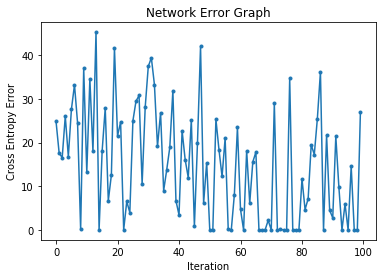

last guess:  7
actual vector:  1
difference:  [ 2.24922859e-13 -1.00000000e+00  5.06634779e-14  1.07097529e-10
  2.06711382e-11  2.97587362e-16  1.03006664e-23  9.99931509e-01
  6.84909940e-05  2.03720256e-16]
accuracy:  24.0 %
number of correct guesses:  24
# times Network Error was zero:  25


In [171]:
lastWeights = trainNetwork(imgtr, .05, [784, 625, 625, 10], tartr)

#### Second Epoch

3 (625,)


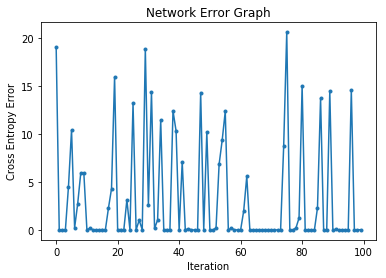

last guess:  1
actual vector:  1
difference:  [ 1.56118678e-14 -1.95992588e-02  4.75930515e-09  2.21823865e-06
  2.04618142e-07  1.85867093e-11  3.86590642e-16  6.27277604e-05
  1.95341034e-02  1.87794238e-14]
accuracy:  65.0 %
number of correct guesses:  65
# times Network Error was zero:  65


In [172]:
lastWeights = trainNetwork(imgtr, .05, [784, 625, 625, 10], tartr, lastWeights)

#### Third Epoch

3 (625,)


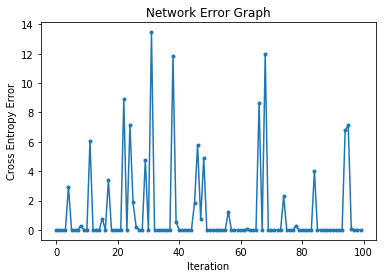

last guess:  1
actual vector:  1
difference:  [ 3.65211118e-11 -1.51150550e-07  4.48006236e-09  8.27973053e-12
  1.97568878e-09  3.35321287e-09  3.72697551e-21  7.98520709e-17
  1.41296769e-07  1.55800337e-14]
accuracy:  79.0 %
number of correct guesses:  79
# times Network Error was zero:  81


In [173]:
lastWeights = trainNetwork(imgtr, .05, [784, 625, 625, 10], tartr, lastWeights)

#### Fourth Epoch

3 (625,)


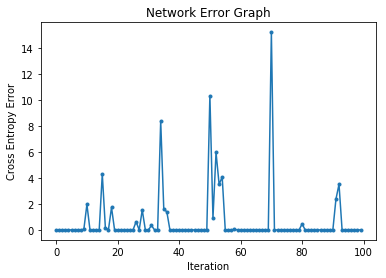

last guess:  1
actual vector:  1
difference:  [ 3.76305548e-16 -5.81608095e-11  1.99842298e-13  4.07805946e-12
  2.27728261e-11  1.52469210e-19  1.66943160e-16  3.11093629e-11
  9.48736142e-17  6.27157809e-24]
accuracy:  85.0 %
number of correct guesses:  85
# times Network Error was zero:  86


In [174]:
lastWeights = trainNetwork(imgtr, .05, [784, 625, 625, 10], tartr, lastWeights)

#### Fifth Epoch

3 (625,)


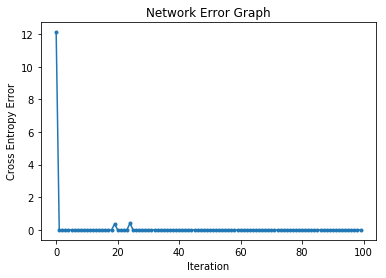

last guess:  1
actual vector:  1
difference:  [ 1.65930018e-12 -7.18139986e-08  1.20756264e-09  5.57065477e-08
  1.59880322e-09  1.31347946e-08  5.26255711e-13  1.62426079e-10
  1.67873176e-12  4.16083974e-17]
accuracy:  99.0 %
number of correct guesses:  99
# times Network Error was zero:  99


In [175]:
lastWeights = trainNetwork(imgtr, .05, [784, 625, 625, 10], tartr, lastWeights)

#### Sixth Epoch....

3 (625,)


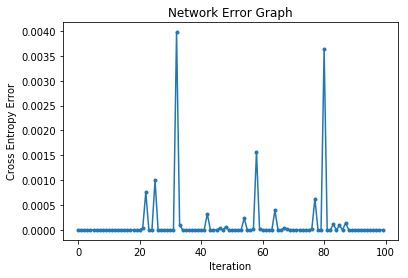

last guess:  1
actual vector:  1
difference:  [ 1.62583356e-12 -6.43448909e-08  1.18511251e-09  4.98096825e-08
  1.59670696e-09  1.15937123e-08  5.42277480e-13  1.55850275e-10
  1.65831247e-12  4.37078788e-17]
accuracy:  100.0 %
number of correct guesses:  100
# times Network Error was zero:  100


In [176]:
lastWeights = trainNetwork(imgtr, .05, [784, 625, 625, 10], tartr, lastWeights)

#### 7th Epoch

3 (625,)


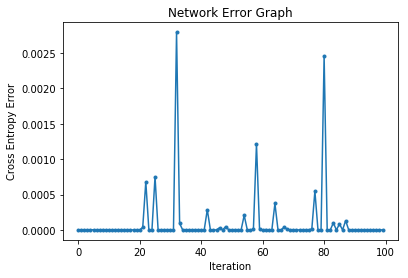

last guess:  1
actual vector:  1
difference:  [ 1.59803526e-12 -5.92634074e-08  1.16629041e-09  4.58339442e-08
  1.59252396e-09  1.05162763e-08  5.52111715e-13  1.50580830e-10
  1.64142671e-12  4.52572252e-17]
accuracy:  100.0 %
number of correct guesses:  100
# times Network Error was zero:  100


In [177]:
lastWeights = trainNetwork(imgtr, .05, [784, 625, 625, 10], tartr, lastWeights)

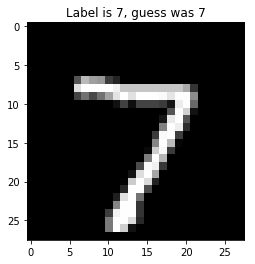

In [178]:
def visualize(patterns, targets, goodOnes):
  
    for i in range(len(goodOnes)):
        # The first column is the label
        label = np.argmax(targets[goodOnes[i][0]])
        guess = goodOnes[i][1]

        # The rest of columns are pixels
        pixels = patterns[goodOnes[i][0]] * 255

        # Make those columns into a array of 8-bits pixels
        # This array will be of 1D with length 784
        # The pixel intensity values are integers from 0 to 255
        pixels = pixels.astype(np.uint8)

        # Reshape the array into 28 x 28 array (2-dimensional array)
        pixels = pixels.reshape((28, 28))
        
        #plot
        plt.title('Label is {label}, guess was {guess}'.format(label=label, guess=guess))
        plt.imshow(pixels, cmap='gray')
        plt.show()
visualize(imgte, tarte, [(0, 7)])

In [179]:
def testNetwork(patterns, targets, weights, good, *showNums):
    errors = []
    numCorrect = 0
    numCorrect2 = 0
    goodOnes = []
    badOnes = []
    
    #Initialize error plot
    fig, ax = plt.subplots()
    
    #Loop through all input vectors, train the network, plot the error
    for p in range(len(patterns)):
        
        #forward pass through network, find all activations
        activations = forwardprop(patterns[p], weights)
        
        #calculate network error
        error = crossEntError(activations[-1], targets[p])
        
        #add to list of errors
        errors.append(error)
        print("Guess/label: ", np.argmax(activations[-1]), np.argmax(targets[p]))
        
        #Did the network guess right?
        if np.argmax(activations[-1]) == np.argmax(targets[p]):
            numCorrect += 1
        
        #Other check
        if int(error) == 0:
            numCorrect2 += 1
            goodOnes.append((p, np.argmax(activations[-1])))
        
        if int(error) >= 1:
            badOnes.append((p, np.argmax(activations[-1])))

    #calculate accuracy
    acc = (numCorrect / len(patterns)) * 100
    
    #plot the error
    ax.plot(errors, marker= '.')
    ax.set(xlabel = 'Iteration', ylabel= 'Cross Entropy Error', title= 'Network Error Graph')
    plt.show()
    
    print("difference: ", (activations[-1] - targets[-1]))
    print("accuracy: ", acc, "%")
    print("number of correct guesses: ", numCorrect)
    print("# times Network Error was zero: ", numCorrect2)
    
    #visualize the numbers that were guessed correctly
    if showNums:
        if good:
            visualize(patterns, targets, goodOnes)
        if not good:
            visualize(patterns, targets, badOnes)
    
    return numCorrect2

Guess/label:  7 7
Guess/label:  2 2
Guess/label:  1 1
Guess/label:  0 0
Guess/label:  4 4
Guess/label:  1 1
Guess/label:  9 4
Guess/label:  5 9
Guess/label:  5 5
Guess/label:  7 9


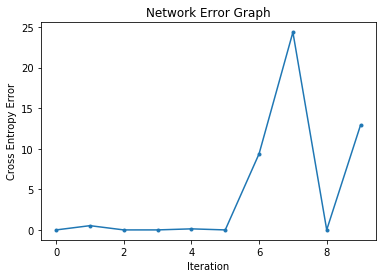

difference:  [ 2.07549561e-09  1.23855360e-12  1.21853169e-14  5.11997923e-13
  2.29281568e-09  9.95068958e-09  2.93635901e-12  9.99997518e-01
  4.47259289e-13 -9.99997532e-01]
accuracy:  70.0 %
number of correct guesses:  7
# times Network Error was zero:  7


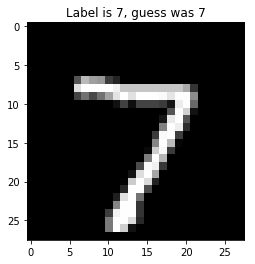

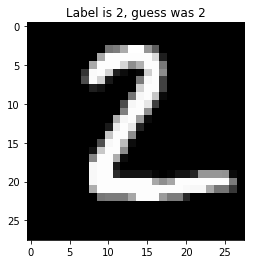

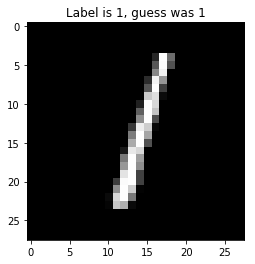

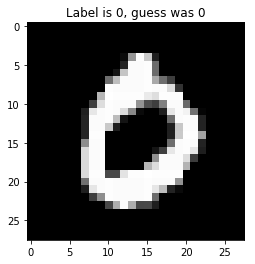

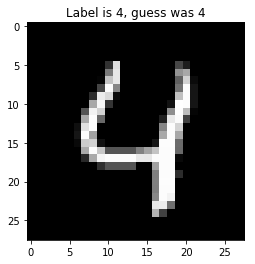

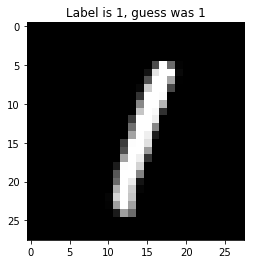

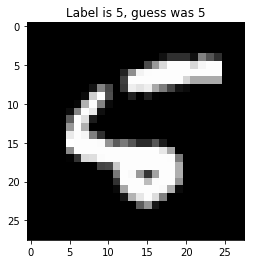

In [183]:
testing = testNetwork(imgte, tarte, lastWeights, True, False)

In [36]:
#testing backprop algorithm on single training pair and network
#VERY SLOW
inputVec2 = imgte[0]
target2 = tarte[0]
neuronsPerLayer1 = [784, 625, 10]
weights2 = []
for layer in range(len(neuronsPerLayer1) - 1):
    weights2.append(np.random.randn(neuronsPerLayer1[layer + 1], neuronsPerLayer1[layer]))
gradientCheck(weights2, inputVec2, target2)
#print(len(inputVec2), len(target2), len(weights2), weights2[0].shape, weights2[1].shape)

0